In [83]:
import json
import os
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import warnings
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, classification_report

In [2]:
warnings.filterwarnings("ignore")

## Data Collection

In [3]:
tickers =['NVDA', 'GOOG', 'SPY', 'QQQ', 'SPOT', 'GLD','JPM','LMT','MSTR', 'UNH']

end_date = datetime.today().date()
start_date = end_date - timedelta(days = 252 * 3)

data = yf.download(tickers, start = start_date, end = end_date, group_by= "ticker", interval = "1d")
vix = yf.download("^VIX", start = start_date, end = end_date, group_by= "ticker", interval = "1d")
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


Ticker            SPOT                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2023-09-06  161.899994  163.649994  159.054993  160.470001  2066500   
2023-09-07  158.570007  161.949997  157.789993  160.100006  1892700   
2023-09-08  159.830002  161.190002  154.399994  155.470001  1713200   
2023-09-11  155.990005  158.070007  154.815002  157.660004  1102200   
2023-09-12  156.649994  158.270004  154.020004  154.649994  1059700   

Ticker             GLD                                               ...  \
Price             Open        High         Low       Close   Volume  ...   
Date                                                                 ...   
2023-09-06  178.330002  179.009995  177.699997  177.830002  6427200  ...   
2023-09-07  178.309998  178.369995  177.899994  178.020004  3257200  ...   
2023-09-08  178.360001  179.050003  177.899994  178.080002  3292700  ...   
2023-09-11  178.970001  179.070007  178.259995  178.410004  3689100  ...   
2023-09-12  177.110001  177.699997  177.050003  177.490005  4445400  ...   

Ticker             UNH                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2023-09-06  462.976790  464.004375  457.493180  458.030975  2596100   
2023-09-07  460.873650  467.797791  459.625202  465.588989  2928000   
2023-09-08  462.947340  465.627514  461.559045  463.506500  1858400   
2023-09-11  464.673088  466.466285  460.835991  462.166443  2059200   
2023-09-12  460.238284  466.273510  455.167150  462.667786  2195200   

Ticker             LMT                                               
Price             Open        High         Low       Close   Volume  
Date                                                                 
2023-09-06  416.916217  417.957945  401.214633  401.479797  2548000  
2023-09-07  401.536649  405.116385  399.642608  403.373871  1195700  
2023-09-08  403.743141  403.847328  399.879311  400.674805  1162300  
2023-09-11  399.850946  400.333935  394.452918  398.373596  1618300  
2023-09-12  397.312907  397.852687  393.903628  395.693481  1307700  

[5 rows x 50 columns]

In [4]:
# Add technical indicators (MA, RSI, MACD) to the dataset
for ticker in tickers:
    # Retrieve the closing prices
    close = data[(ticker, 'Close')]

    # Compute 5-day, 20-day and 50-day moving averages of closing prices
    data[(ticker, 'MA5')] = close.rolling(window = 5).mean()
    data[(ticker, 'MA20')] = close.rolling(window = 20).mean()
    data[(ticker, 'MA50')] = close.rolling(window = 50).mean()

    # Compute MACD
    short_ema = close.ewm(span = 12, adjust = False).mean()
    long_ema = close.ewm(span = 26, adjust = False).mean()
    data[(ticker, 'MACD')] = short_ema - long_ema
    data[(ticker, 'MACD_signal_line')] = data[(ticker, 'MACD')].ewm(span = 9, adjust= False).mean()

    # Compute daily returns and indicate whether each is positive or negative
    returns = close.pct_change()
    data[(ticker,'daily_ret')] = returns
    data[(ticker, 'positive')] = (returns > 0).astype(int)

    # Compute short term volatility on a rolling basis
    data[(ticker, 'vol5')] = returns.rolling(window= 5).std() 
    data[(ticker, 'vol20')] = returns.rolling(window= 20).std() 
    data[(ticker, 'vol50')] = returns.rolling(window= 50).std() 

    # Compute the 14-day RSI
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / loss
    data[(ticker, 'RSI_14')] = 100 - (100 / (1 + rs))

    # Add lagged daily returns to capture time-series memory
    for lag in range(1, 50):
        data[(ticker, f'lag{lag}')] = returns.shift(lag)

   # Compute next-day price and corresponding return
    data[(ticker, 'next_day_price')] = close.shift(-1)
    data[(ticker, 'next_day_ret')] = returns.shift(-1)
    data[(ticker, 'positive_next_day')] = data[(ticker, 'positive')].shift(-1)

    # Add earnings dates
    earning_df = yf.Ticker(ticker).get_earnings_dates(limit= 4 * 3)
    if earning_df is not None and not earning_df.empty:
        earnings_dates = earning_df.index.tz_localize(None).normalize()
    else:
        earnings_dates = []
    
    data[(ticker, 'earnings')] = data.index.isin(earnings_dates)
    data[(ticker, 'earnings_next_day')] = data[(ticker, 'earnings')].shift(-1)

GLD: $GLD: possibly delisted; no earnings dates found


In [5]:
# Select features, reorder columns, and drop null values
features = ["Volume", "earnings", "Close", "vol5", "vol20", "MA5", "MA20", "MA50", "MACD", "daily_ret"]
lagged_features = [f"lag{lag}" for lag in range(1, 50)]
reorder_cols = [(ticker, attr) for ticker in tickers for attr in features + lagged_features + ["next_day_ret", "positive_next_day"]]

final_data = data[reorder_cols]
final_data = final_data.dropna()
final_data

Ticker           NVDA                                                       \
Price          Volume earnings       Close      vol5     vol20         MA5   
Date                                                                         
2023-11-15  475497000    False   48.859207  0.017154  0.022755   48.461236   
2023-11-16  339756000    False   49.450855  0.017144  0.022653   48.966939   
2023-11-17  325205000    False   49.268967  0.014202  0.022059   49.159427   
2023-11-20  414120000    False   50.379303  0.016510  0.021218   49.517016   
2023-11-21  565747000     True   49.914581  0.015688  0.021480   49.574583   
...               ...      ...         ...       ...       ...         ...   
2025-09-23  192559600    False  178.429993  0.032234  0.021420  177.047998   
2025-09-24  143564100    False  176.970001  0.028760  0.021326  178.384000   
2025-09-25  191586700    False  177.690002  0.024550  0.021358  178.673999   
2025-09-26  148573700    False  178.190002  0.024553  0.021307  178.978000   
2025-09-29  193063500    False  181.850006  0.017980  0.020305  178.626001   

Ticker                                                  ...       UNH  \
Price             MA20        MA50      MACD daily_ret  ...     lag42   
Date                                                    ...             
2023-11-15   44.285749   44.252058  1.329092 -0.015466  ... -0.001315   
2023-11-16   44.654482   44.316800  1.454483  0.012109  ... -0.011110   
2023-11-17   45.049799   44.391276  1.521639 -0.003678  ...  0.023863   
2023-11-20   45.421280   44.495834  1.645487  0.022536  ...  0.018308   
2023-11-21   45.735145   44.597255  1.686695 -0.009224  ...  0.009897   
...                ...         ...       ...       ...  ...       ...   
2025-09-23  175.347604  176.198860  0.904871 -0.028212  ... -0.047622   
2025-09-24  175.108116  176.324453  0.863452 -0.008182  ...  0.008902   
2025-09-25  174.913128  176.451046  0.878597  0.004068  ...  0.003771   
2025-09-26  174.814636  176.555042  0.920337  0.002814  ... -0.074614   
2025-09-29  175.198628  176.744036  1.234517  0.020540  ...  0.019037   

Ticker                                                                  \
Price          lag43     lag44     lag45     lag46     lag47     lag48   
Date                                                                     
2023-11-15  0.006410  0.007836 -0.000125  0.001085 -0.002891 -0.004473   
2023-11-16 -0.001315  0.006410  0.007836 -0.000125  0.001085 -0.002891   
2023-11-17 -0.011110 -0.001315  0.006410  0.007836 -0.000125  0.001085   
2023-11-20  0.023863 -0.011110 -0.001315  0.006410  0.007836 -0.000125   
2023-11-21  0.018308  0.023863 -0.011110 -0.001315  0.006410  0.007836   
...              ...       ...       ...       ...       ...       ...   
2025-09-23  0.025883  0.010598 -0.001804 -0.018815 -0.015112  0.002674   
2025-09-24 -0.047622  0.025883  0.010598 -0.001804 -0.018815 -0.015112   
2025-09-25  0.008902 -0.047622  0.025883  0.010598 -0.001804 -0.018815   
2025-09-26  0.003771  0.008902 -0.047622  0.025883  0.010598 -0.001804   
2025-09-29 -0.074614  0.003771  0.008902 -0.047622  0.025883  0.010598   

Ticker                                               
Price          lag49 next_day_ret positive_next_day  
Date                                                 
2023-11-15  0.016501     0.002619               1.0  
2023-11-16 -0.004473    -0.006539               0.0  
2023-11-17 -0.002891    -0.002219               0.0  
2023-11-20  0.001085     0.008391               1.0  
2023-11-21 -0.000125     0.007728               1.0  
...              ...          ...               ...  
2025-09-23 -0.029510     0.011850               1.0  
2025-09-24  0.002674    -0.017765               0.0  
2025-09-25 -0.015112    -0.004283               0.0  
2025-09-26 -0.018815     0.003197               1.0  
2025-09-29 -0.001804     0.000348               1.0  

[468 rows x 610 columns]

In [6]:
# Retrieve VIX for the selected period as a proxy for overall market volatility
vix_data = vix[-len(final_data)-1: -1][('^VIX','Close')]
vix_data

Date
2023-11-15    14.180000
2023-11-16    14.320000
2023-11-17    13.800000
2023-11-20    13.410000
2023-11-21    13.350000
                ...    
2025-09-23    16.639999
2025-09-24    16.180000
2025-09-25    16.740000
2025-09-26    15.290000
2025-09-29    16.120001
Name: (^VIX, Close), Length: 468, dtype: float64

## Preditive Modeling

### K-nearest-neighbors (KNN)

In [7]:
split_idx = int(len(final_data) * 0.8)
X_trains, X_tests, y_trains, y_tests, train_pred_knn, test_pred_knn, k_vals = [{} for _ in range(7)]

# Apply KNN regression for each ticker
for ticker in tickers:
    X = pd.concat([final_data[(ticker, feature)] for feature in features],axis=1)
    y = final_data[(ticker, 'next_day_ret')]

    pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor())])

    # Train-test split
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    X_trains[ticker], X_tests[ticker] = X_train, X_test
    y_trains[ticker], y_tests[ticker] = y_train,y_test

    # Perform time series cross-validation and run a grid search to select the best k 
    tscv = TimeSeriesSplit(n_splits= 10)
    grid = {"knn__n_neighbors": list(range(1, 100))}
    search = GridSearchCV(pipe, grid, cv = tscv, scoring = "neg_mean_squared_error", n_jobs = -1, refit = False)

    search.fit(X_train,y_train)
    best_k = search.best_params_["knn__n_neighbors"]
    k_vals[ticker] = best_k

    final_pipe = Pipeline([("scaler", StandardScaler()), 
                       ("knn", KNeighborsRegressor(n_neighbors = best_k))])

    final_pipe.fit(X_train, y_train)
    y_train_pred = final_pipe.predict(X_train)
    y_test_pred = final_pipe.predict(X_test)

    train_pred_knn[ticker], test_pred_knn[ticker] = y_train_pred, y_test_pred

### Performance of KNN

In [8]:
knn = pd.DataFrame(columns = ['Ticker', 'K_value','R2_train','R2_test','RMSE_train','RMSE_test'])

knn['Ticker'] = tickers
knn['K_value'] = k_vals.values()
knn['R2_train'] = [r2_score(y_trains[ticker],train_pred_knn[ticker]) for ticker in tickers]
knn['R2_test'] = [r2_score(y_tests[ticker],test_pred_knn[ticker]) for ticker in tickers]
knn['RMSE_train'] = [math.sqrt(mean_squared_error(y_trains[ticker],train_pred_knn[ticker])) for ticker in tickers]
knn['RMSE_test'] = [math.sqrt(mean_squared_error(y_tests[ticker],test_pred_knn[ticker])) for ticker in tickers]

knn = knn.set_index('Ticker')
knn

K_value  R2_train   R2_test  RMSE_train  RMSE_test
Ticker                                                    
NVDA         34  0.073341 -0.168339    0.033944   0.018858
GOOG         34  0.014918 -0.044205    0.018975   0.016500
SPY          13  0.039171 -0.466916    0.010929   0.007467
QQQ          32  0.024629 -0.351142    0.014030   0.008518
SPOT         27  0.061332 -0.013249    0.025150   0.024981
GLD          34  0.008423 -0.045598    0.010334   0.009688
JPM          28  0.024471 -0.047581    0.015725   0.010446
LMT          27  0.055820  0.004135    0.012633   0.016623
MSTR         18  0.054237 -0.174008    0.063831   0.034359
UNH          25  0.058271 -0.204619    0.022827   0.030833

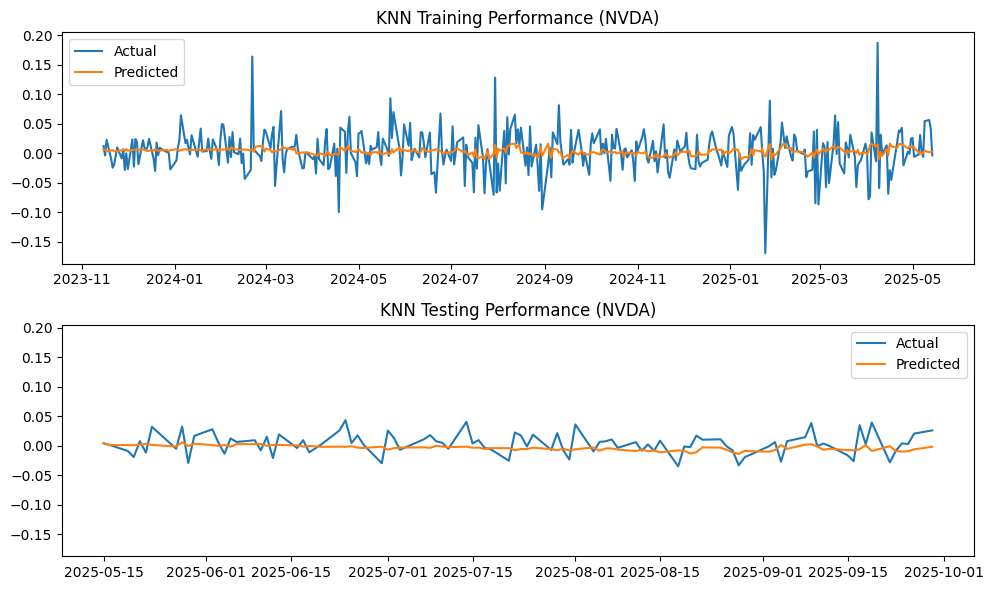

Best K for KNN: 34
Train R squared: 0.073,  RMSE: 0.034
Test R squared: -0.168,  RMSE: 0.019


In [9]:
ticker = "NVDA"
train_actual, train_pred = y_trains[ticker], train_pred_knn[ticker]
test_actual, test_pred = y_tests[ticker], test_pred_knn[ticker]

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=True)

axes[0].plot(train_actual.index, train_actual, label="Actual")
axes[0].plot(train_actual.index, train_pred, label="Predicted")
axes[0].set_title(f"KNN Training Performance ({ticker})")
axes[0].legend()

axes[1].plot(test_actual.index, test_actual, label="Actual")
axes[1].plot(test_actual.index, test_pred, label="Predicted")
axes[1].set_title(f"KNN Testing Performance ({ticker})")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Best K for KNN: {k_vals[ticker]}")
print(f"Train R squared: {knn.loc[ticker, 'R2_train']:.3f},  RMSE: {knn.loc[ticker, 'RMSE_train']:.3f}")
print(f"Test R squared: {r2_score(test_actual, test_pred):.3f},  RMSE: {math.sqrt(mean_squared_error(test_actual, test_pred)):.3f}")

### Analysis of KNN

The $R^2$ score for KNN on the training set is nearly 0, which is only slightly better than the baseline. In addition, we see that the predicted return rate is nearly zero, while the actual return is more volatile than the prediction. The model’s underestimation of volatility likely stems from relying solely on technical indicators from past prices and not accounting for market events such as headlines or earnings calls.

### KNN on return direction

In [107]:
y_trains_2,y_tests_2, train_pred_knn_2, test_pred_knn_2, new_k_vals, tomorrow = [{} for _ in range(6)]
pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])

# Apply KNN regression for each ticker
for ticker in tickers:
    X_train, X_test = X_trains[ticker], X_tests[ticker]
    
    y = final_data[(ticker, 'positive_next_day')]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    y_trains_2[ticker], y_tests_2[ticker] = y_train, y_test

    #Time series CV + grid search for best k
    tscv = TimeSeriesSplit(n_splits= 5)
    grid = {"knn__n_neighbors": list(range(1, 100))}
    search = GridSearchCV(pipe, grid, cv=tscv, scoring="accuracy", n_jobs=-1, refit=True)

    search.fit(X_train,y_train)
    best_model = search.best_estimator_
    train_pred_knn_2[ticker] = best_model.predict(X_train)
    test_pred_knn_2[ticker] = best_model.predict(X_test)
    new_k_vals[ticker] = search.best_params_["knn__n_neighbors"]

    # Predict tomorrow's price movement
    latest = latest = pd.concat([data[(ticker, feature)].iloc[[-1]] for feature in features],axis=1)
    tomorrow[ticker] = best_model.predict(latest)

In [11]:
knn2 = pd.DataFrame(columns = ['Ticker','K_value','train_pred_accuracy','test_pred_accuracy','baseline (always positive)'])

knn2['Ticker'] = tickers
knn2['K_value'] = new_k_vals.values()
knn2['train_pred_accuracy'] = [round(accuracy_score(y_trains_2[ticker], train_pred_knn_2[ticker]),3) for ticker in tickers]
knn2['test_pred_accuracy'] = [round(accuracy_score(y_tests_2[ticker], test_pred_knn_2[ticker]),3) for ticker in tickers]
knn2['baseline (always positive)'] = [round(y_tests_2[ticker].mean(),3) for ticker in tickers]

knn2 = knn2.set_index('Ticker')
knn2

K_value  train_pred_accuracy  test_pred_accuracy  \
Ticker                                                     
NVDA          1                1.000               0.468   
GOOG         16                0.642               0.638   
SPY          35                0.602               0.500   
QQQ          35                0.607               0.468   
SPOT         51                0.596               0.606   
GLD          57                0.578               0.585   
JPM          58                0.572               0.585   
LMT          54                0.537               0.521   
MSTR          6                0.658               0.596   
UNH          22                0.602               0.521   

        baseline (always positive)  
Ticker                              
NVDA                         0.585  
GOOG                         0.574  
SPY                          0.564  
QQQ                          0.617  
SPOT                         0.564  
GLD                          0.585  
JPM                          0.606  
LMT                          0.617  
MSTR                         0.436  
UNH                          0.532

As we can see, for all but one stock, our prediction accuracy is greater than 50%, i.e. predicting up or down by a coin toss. The best result is for SPOT, where we achieved 61.7% prediction accuracy on the testing set. Another baseline prediction is to always bet that the stock price will go up the next day (based on the selection bias that the stocks chosen are popular in the market). Four stocks outperform this baseline: GOOG, SPOT, MSTR, and UNH. Therefore, the KNN model provides us with an edge in predicting whether the stock price will rise the following day.

### Kernel Ridge Regression

In [12]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler

In [13]:
train_pred_krr, test_pred_krr, best_params = {}, {}, {}
# Apply Kernel Ridge regression for each ticker
for ticker in tickers:
    X_train, X_test = X_trains[ticker], X_tests[ticker]
    y_train, y_test = y_trains[ticker], y_tests[ticker]

    pipe = Pipeline([("scaler", RobustScaler()), ("krr", KernelRidge())])

    # Perform time series cross-validation and choose hyperparameter
    tscv = TimeSeriesSplit(n_splits=10)
    param_grid = {"krr__alpha": [1e-6, 1e-5, 1e-4,1e-3, 1e-2, 1e-1, 0.05, 1, 10, 20, 30], 
              "krr__gamma": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.05, 0.1, 0.5, 1, 5, 10, 20]}
    
    # USE RMSE as score
    scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
    search = GridSearchCV(pipe, param_grid, cv=tscv, scoring= scorer, n_jobs=-1, refit=True) 

    # Fit the model and store the predicted values
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    train_pred_krr[ticker] = best_model.predict(X_train)
    test_pred_krr[ticker] = best_model.predict(X_test) 
    best_params[ticker] = search.best_params_

### Performance of Kernel Ridge Regression

In [14]:
krr = pd.DataFrame(columns = ['Ticker', 'alpha','gamma', 'R2_train','R2_test','RMSE_train','RMSE_test'])

krr['Ticker'] = tickers
krr['alpha'] = [best_params[ticker]['krr__alpha'] for ticker in tickers]
krr['gamma'] = [best_params[ticker]['krr__gamma'] for ticker in tickers]
krr['R2_train'] = [r2_score(y_trains[ticker],train_pred_krr[ticker]) for ticker in tickers]
krr['R2_test'] = [r2_score(y_tests[ticker],test_pred_krr[ticker]) for ticker in tickers]
krr['RMSE_train'] = [math.sqrt(mean_squared_error(y_trains[ticker],train_pred_krr[ticker])) for ticker in tickers]
krr['RMSE_test'] = [math.sqrt(mean_squared_error(y_tests[ticker],test_pred_krr[ticker])) for ticker in tickers]

krr = krr.set_index('Ticker')
krr

alpha     gamma  R2_train   R2_test  RMSE_train  RMSE_test
Ticker                                                               
NVDA    0.000001  0.000001  0.047261 -0.442095    0.034418   0.020951
GOOG    0.000001  0.000001  0.026458 -0.201753    0.018864   0.017701
SPY     0.000001  0.000001  0.050347 -0.646734    0.010865   0.007911
QQQ     0.000001  0.000001  0.031776 -0.384549    0.013979   0.008623
SPOT    0.000001  0.000001  0.038163  0.007684    0.025458   0.024722
GLD     0.000001  0.000001  0.015533 -0.026761    0.010297   0.009600
JPM     0.000001  0.000001  0.013500 -0.337136    0.015814   0.011802
LMT     0.000001  0.000001  0.036997 -0.047667    0.012758   0.017050
MSTR    0.000001  0.000001  0.025581 -0.014212    0.064791   0.031935
UNH     0.000001  0.000001  0.071380 -0.519966    0.022667   0.034635

### Support Vector Machine

In [15]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [16]:
train_pred_svc, test_pred_svc, best_params_svc = {}, {}, {}
# Apply Kernel Ridge regression for each ticker
for ticker in tickers:
    X_train, X_test = X_trains[ticker], X_tests[ticker]
    y_train, y_test = y_trains_2[ticker], y_tests_2[ticker]

    pipe = Pipeline([("scaler", RobustScaler()), 
                     ("pca", PCA(n_components=0.95, svd_solver="full")),
                     ("svc", SVC())])

    # Perform time series cross-validation and choose hyperparameter
    tscv = TimeSeriesSplit(n_splits= 8)
    param_grid = {
        "svc__C": [0.1, 1, 10, 50, 100],
        "svc__gamma": [1e-4, 1e-3, 1e-2, 0.1, 1, 10],
        "svc__kernel": ["rbf"],                              
        "svc__class_weight": [None, "balanced"]     
    }
    
    search = GridSearchCV(pipe, param_grid, cv=tscv, scoring= "accuracy", n_jobs=-1, refit=True) 

    # Fit the model and store the predicted values
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    train_pred_svc[ticker] = best_model.predict(X_train)
    test_pred_svc[ticker] = best_model.predict(X_test) 
    best_params_svc[ticker]= search.best_params_

In [17]:
svc = pd.DataFrame(columns = ['Ticker','train_pred_accuracy','test_pred_accuracy','baseline (always positive)'])

svc['Ticker'] = tickers
svc['train_pred_accuracy'] = [round(accuracy_score(y_trains_2[ticker], train_pred_svc[ticker]),3) for ticker in tickers]
svc['test_pred_accuracy'] = [round(accuracy_score(y_tests_2[ticker], test_pred_svc[ticker]),3) for ticker in tickers]
svc['baseline (always positive)'] = [round(y_tests_2[ticker].mean(),3) for ticker in tickers]

svc = svc.set_index('Ticker')
svc

train_pred_accuracy  test_pred_accuracy  baseline (always positive)
Ticker                                                                     
NVDA                  0.695               0.489                       0.585
GOOG                  0.570               0.564                       0.574
SPY                   0.594               0.564                       0.564
QQQ                   0.583               0.617                       0.617
SPOT                  0.567               0.564                       0.564
GLD                   0.757               0.585                       0.585
JPM                   0.588               0.606                       0.606
LMT                   0.570               0.585                       0.617
MSTR                  0.489               0.564                       0.436
UNH                   0.516               0.532                       0.532

## Markowitz Portfolio Theory

In [115]:
windows_size = 30
returns_df = pd.DataFrame({ticker: final_data[(ticker, 'daily_ret')] for ticker in tickers})
returns_win = returns_df[-windows_size:]

# Compute the expected returns and the covariance matrix
mu = returns_win.mean().values
cov = returns_win.cov().values
cov += 1e-5 * np.eye(len(cov))   

n = len(mu)
ones = np.ones(n)

inv_cov = np.linalg.inv(cov)
weights = inv_cov @ ones / (ones @ inv_cov @ ones)

# portfolio stats
port_return = weights @ mu
port_vol = np.sqrt(weights @ cov @ weights)

### The portfolio weights

In [117]:
portfolio = pd.DataFrame(columns = ['Ticker', 'Weights','Current_Price', "Predicted_Direction"])
portfolio['Ticker'] = tickers
portfolio['Weights'] = weights * 100
portfolio['Current_Price'] = [round(float(final_data.iloc[-1][(ticker, 'Close')]),2) for ticker in tickers]
portfolio['Predicted_Direction'] = ["↑" if tomorrow[ticker][0] == 1 else "↓" for ticker in tickers]
portfolio = portfolio.set_index('Ticker')
portfolio['Weights'] = portfolio['Weights'].map(lambda x: f"{x:.2f}%")
print(f"Portfolio as of {end_date}")
print(f"The expected annualized return: {port_return * 252 * 100: .2f}%")
portfolio

Portfolio as of 2025-10-01
The expected annualized return:  81.65%


Weights  Current_Price Predicted_Direction
Ticker                                           
NVDA    -7.61%         181.85                   ↓
GOOG    -2.23%         244.36                   ↓
SPY     19.68%         663.68                   ↓
QQQ      9.53%         598.73                   ↓
SPOT    13.99%         728.47                   ↑
GLD     22.67%         352.46                   ↑
JPM     19.29%         315.69                   ↑
LMT     26.36%         491.98                   ↑
MSTR    -5.87%         326.42                   ↓
UNH      4.20%         345.18                   ↑

In [124]:
# Save to JSON in current directory
weights_dict = {ticker: weights[i] * 100 for i, ticker in enumerate(tickers)}
direction_dict = {ticker: "Up" if tomorrow[ticker][0] == 1 else "Down" for ticker in tickers}

with open(os.path.join(os.getcwd(), "portfolio_weights.json"), "w") as f:
    json.dump(weights_dict, f, indent=4)

with open(os.path.join(os.getcwd(), "portfolio_directions.json"), "w") as f:
    json.dump(direction_dict, f, indent=4)